---
title: "Movie Lens - Collaborative Filtering based Recommendation System"
description: "Movie Recommendation Using PySpark"
author: "Sagar Thacker"
date: "2022-01-20"
categories: [PySpark]
image: "movie-recommendation.jpeg"
format:
    html:
        toc: true
        code-overflow: wrap
        code-line-numbers: true
jupyter: python3
---


Recommendation System are build by analyzing the user and product interation data. It can be used to give item suggestion to a user or predict how a user would rate the an item.

Recommendation System have mainly have three approaches:

1. Content Based Filtering
2. Collaborative Filtering
3. Hybrid Approach

In this notebook, Alternating Least Squares (ALS) matrix factorization algorithm with the use of Apache Spark APIs to predict the ratings of movies in the MovieLens Dataset.

ALS attempts to estimate the ratings matrix R as the product of two lower-rank matrices, `X` and `Y`, i.e. `X * Yt = R`. Typically these approximations are called ‘**factor**’ matrices. The general approach is iterative. During each iteration, one of the factor matrices is held constant, while the other is solved for using least squares. The newly-solved factor matrix is then held constant while solving for the other factor matrix ([source](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html)).


In [55]:
# | code-fold: true
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline
os.environ["PYSPARK_PYTHON"] = "python3"
warnings.filterwarnings('ignore')


## 1. Data Description

MovieLens 25M movie ratings. Stable benchmark dataset. 25 million ratings and one million tag applications applied to 62,000 movies by 162,000 users.

a. `movies.csv`: Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has the following format: `movieId,title,genres`

Genres are a pipe-separated list, and are selected from the following:

-   Action
-   Adventure
-   Animation
-   Children's
-   Comedy
-   Crime
-   Documentary
-   Drama
-   Fantasy
-   Film-Noir
-   Horror
-   Musical
-   Mystery
-   Romance
-   Sci-Fi
-   Thriller
-   War
-   Western
-   (no genres listed)

b. `rating.csv`: All ratings are contained in the file `rating.csv`. Each line of this file after the header row represents one rating of one movie by one user, and has the following format: `userId,movieId,rating,timestamp`

The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.


## 2. Overview Structure and Data Content


In [3]:
# Create a spark session
spark = SparkSession.builder.appName(
    "movie-lens-recommendation").config("spark.driver.memory", "16g").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/21 01:45:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Read dataset
__dirname = '../input/movielens-20m-dataset/'
movies = spark.read.csv(__dirname + 'movie.csv', header=True, inferSchema=True)
ratings = spark.read.csv(__dirname + 'rating.csv',
                         header=True, inferSchema=True)


In [5]:
# Shape of the datasets
print(f'Movies has {movies.count()} rows and {len(movies.columns)} columns')
print(f'Ratings has {ratings.count()} rows and {len(ratings.columns)} colunms')


Movies has 27278 rows and 3 columns


Ratings has 20000263 rows and 4 colunms


In [7]:
# Display top five rows of each dataframe
movies.show(n=5, truncate=False)
ratings.show(n=5, truncate=False)


+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows

+------+-------+------+-------------------+
|userId|movieId|rating|timestamp          |
+------+-------+------+-------------------+
|1     |2      |3.5   |2005-04-02 23:53:47

### 2.1. Data Structure and Statistics

Let's go over each dataframe and check it's schema.

Run the `describe()` method to see the count, mean, standard deviation, minimum, and maximum values for the data in each column:


In [8]:
# Movies DataFrame
movies.printSchema()
movies.describe().show()


root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



+-------+-----------------+--------------------+------------------+
|summary|          movieId|               title|            genres|
+-------+-----------------+--------------------+------------------+
|  count|            27278|               27278|             27278|
|   mean|59855.48057042305|                null|              null|
| stddev|44429.31469707313|                null|              null|
|    min|                1|""Great Performan...|(no genres listed)|
|    max|           131262|       貞子3D (2012)|           Western|
+-------+-----------------+--------------------+------------------+



In [9]:
# Ratings DataFrame
ratings.printSchema()
ratings.summary().show()


root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



+-------+-----------------+------------------+------------------+
|summary|           userId|           movieId|            rating|
+-------+-----------------+------------------+------------------+
|  count|         20000263|          20000263|          20000263|
|   mean|69045.87258292554| 9041.567330339605|3.5255285642993797|
| stddev|40038.62665316267|19789.477445413264| 1.051988919294229|
|    min|                1|                 1|               0.5|
|    25%|            34395|               903|               3.0|
|    50%|            69133|              2167|               3.5|
|    75%|           103637|              4771|               4.0|
|    max|           138493|            131262|               5.0|
+-------+-----------------+------------------+------------------+



Not all of these statistics are actually meaningful!<br>
You can use specific methods from the DataFrame API to compute any statistic:


In [10]:
print(
    f"Number of distinct users: {ratings.select('userId').distinct().count()}")
print(
    f"Number of distinct movies: {ratings.select('movieId').distinct().count()}")


Number of distinct users: 138493


Number of distinct movies: 26744


You can also leverage your SQL knowledge to query the data.

Example, Find the number of movies with ratings higher than 4 with and without SQL:


In [12]:
# Without SQL
print(
    f"Number of distinct movies with rating greater than 4: {ratings.filter('rating > 4').select('movieId').distinct().count()}")

# With SQL
ratings.createOrReplaceTempView('ratings')
spark.sql('SELECT COUNT(DISTINCT(movieId)) AS movie_count FROM ratings WHERE rating > 4').show()


Number of distinct movies with rating greater than 4: 17218


+-----------+
|movie_count|
+-----------+
|      17218|
+-----------+



### 2.2. Missing Values

Check if any column contains missing values.


In [13]:
# Check for missing values
# 1. Movies Dataframe
movies.select([F.count(F.when(F.col(c).contains('NULL') |
                              F.col(c).isNull() |
                              F.isnan(c), c)).alias(c) for c in movies.columns]).show()

# 2. Ratings Dataframe
ratings.select(*[(
    F.count(
        F.when(
            (F.col(c).contains('NULL') | F.col(c).isNull() | F.isnan(c)), c)) if t not in ('timestamp', 'data')
    else F.count(F.when(F.col(c).contains('NULL') | F.col(c).isNull(), c))).alias(c)
    for c, t in ratings.dtypes]).show()


+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+



+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+



### 2.3. Merge DataFrame

We'll merge the `movies` and `ratings` dataframe for further analysis and model building process.


In [14]:
# Merge the movies and ratings dataframes
df = ratings.join(movies, on=["movieId"], how="left")


In [15]:
# Look at df structure
df.printSchema()
print(f'Merged DataFrame has {df.count()} rows and {len(df.columns)} colunms')


root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



Merged DataFrame has 20000263 rows and 6 colunms


In [16]:
# Display top five rows of merged dataframe
df.show(n=5, truncate=False)


+-------+------+------+-------------------+---------------------------------------------------------------+--------------------------------------+
|movieId|userId|rating|timestamp          |title                                                          |genres                                |
+-------+------+------+-------------------+---------------------------------------------------------------+--------------------------------------+
|2      |1     |3.5   |2005-04-02 23:53:47|Jumanji (1995)                                                 |Adventure|Children|Fantasy            |
|29     |1     |3.5   |2005-04-02 23:31:16|City of Lost Children, The (Cité des enfants perdus, La) (1995)|Adventure|Drama|Fantasy|Mystery|Sci-Fi|
|32     |1     |3.5   |2005-04-02 23:33:39|Twelve Monkeys (a.k.a. 12 Monkeys) (1995)                      |Mystery|Sci-Fi|Thriller               |
|47     |1     |3.5   |2005-04-02 23:32:07|Seven (a.k.a. Se7en) (1995)                                    |Mystery|Thr

## 3. Visualizations


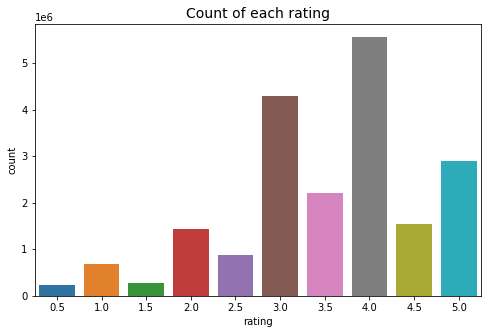

In [17]:
# Distribution of User Ratings
rating_count_df = (df.groupBy(['rating']).count()).toPandas()

fig = plt.figure(figsize=(8, 5))
sns.barplot(x='rating', y='count', data=rating_count_df)
plt.title("Count of each rating", fontsize=14)
plt.show()


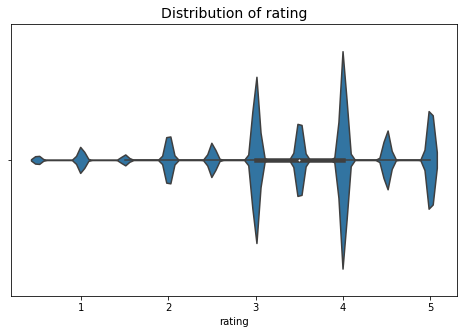

In [24]:
rating_values = df.select(['rating']).toPandas()

fig = plt.figure(figsize=(8, 5))
sns.violinplot(rating_values['rating'])
plt.title("Distribution of rating", fontsize=14)
plt.show()


We find:

-   Most of the users have rated `4.0` followed by `3.0`.


In [25]:
genre_rating = (df
                .select("movieId", "userId", "genres", "rating")
                .withColumn("genres_array", F.split("genres", "\|"))
                .withColumn("genre", F.explode("genres_array"))
                .groupBy("genre").agg(F.mean(F.col("rating")).alias("genre_rating"),
                                      F.countDistinct("movieId").alias(
                                          "num_movies"),
                                      F.countDistinct("movieId", "userId").alias("num_ratings"))
                ).toPandas()


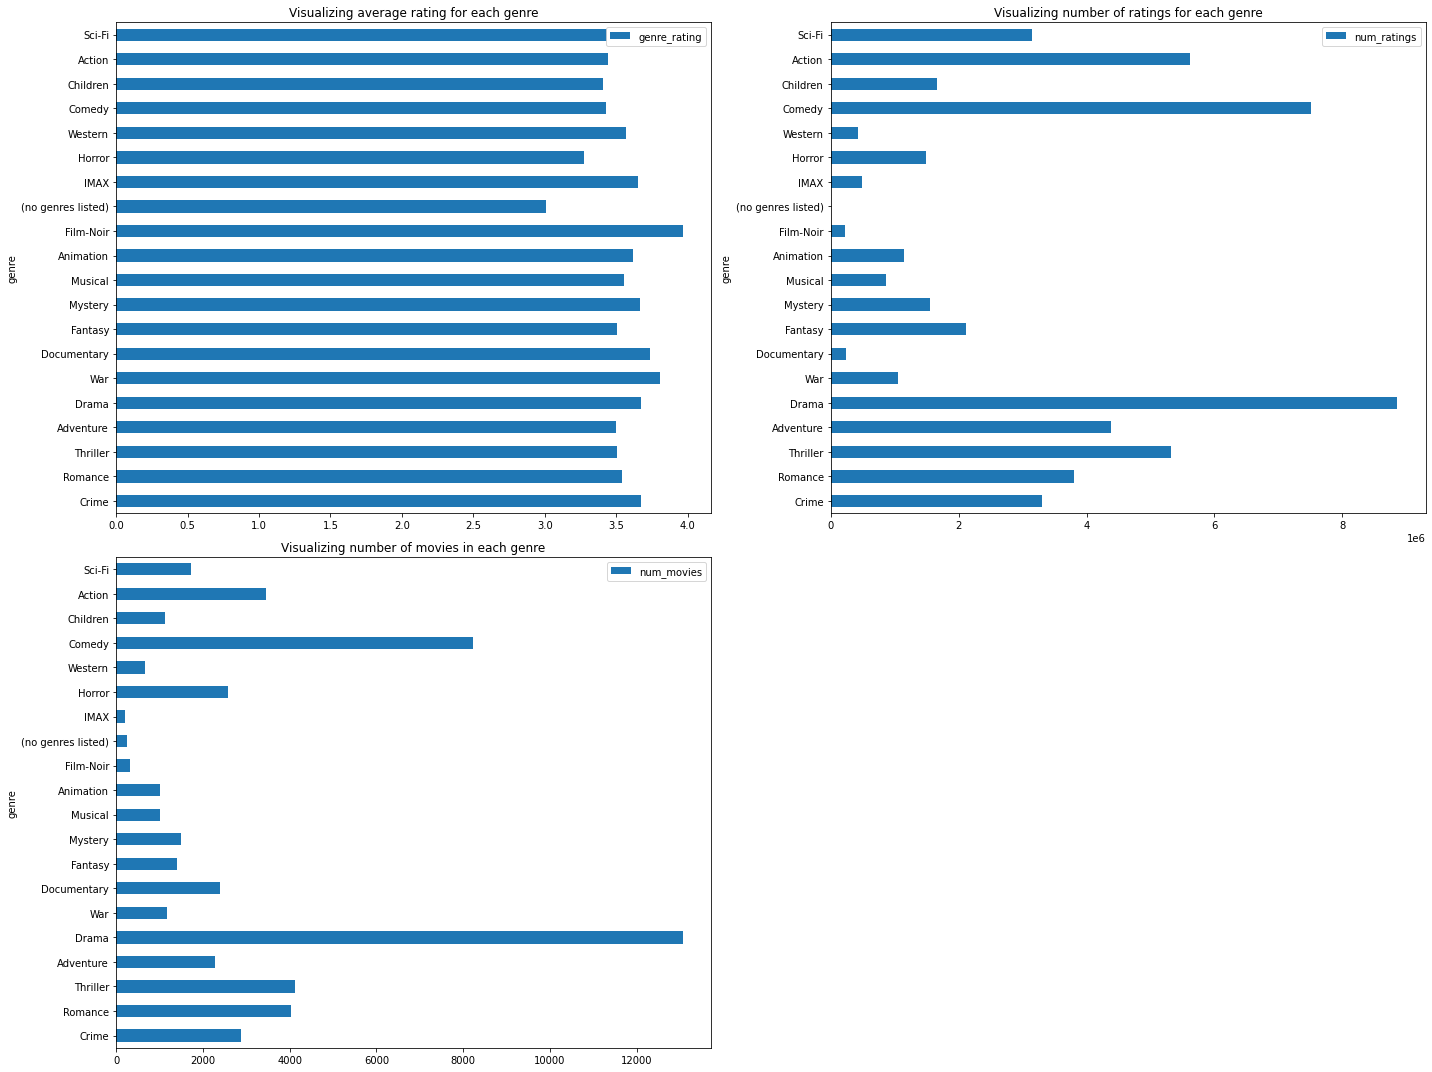

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

genre_rating.plot.barh("genre", "genre_rating", ax=axes[0, 0])
axes[0, 0].set_title("Visualizing average rating for each genre")

genre_rating.plot.barh("genre", "num_ratings", ax=axes[0, 1])
axes[0, 1].set_title("Visualizing number of ratings for each genre")

genre_rating.plot.barh("genre", "num_movies", ax=axes[1, 0])
axes[1, 0].set_title("Visualizing number of movies in each genre")

fig.delaxes(axes[1, 1])
fig.tight_layout()

plt.show()


In [35]:
# Analyzing day of the month - Timestamp of rating
day_month_rating = (df
                    .withColumnRenamed("timestamp", "date")
                    .withColumn("day", F.dayofmonth(F.col("date")))
                    .groupBy("day").agg(F.mean(F.col("rating")).alias("avg_rating"),
                                        F.countDistinct("movieId").alias(
                                            "num_movies"),
                                        F.countDistinct("movieId", "userId").alias("num_ratings"))
                    ).toPandas()


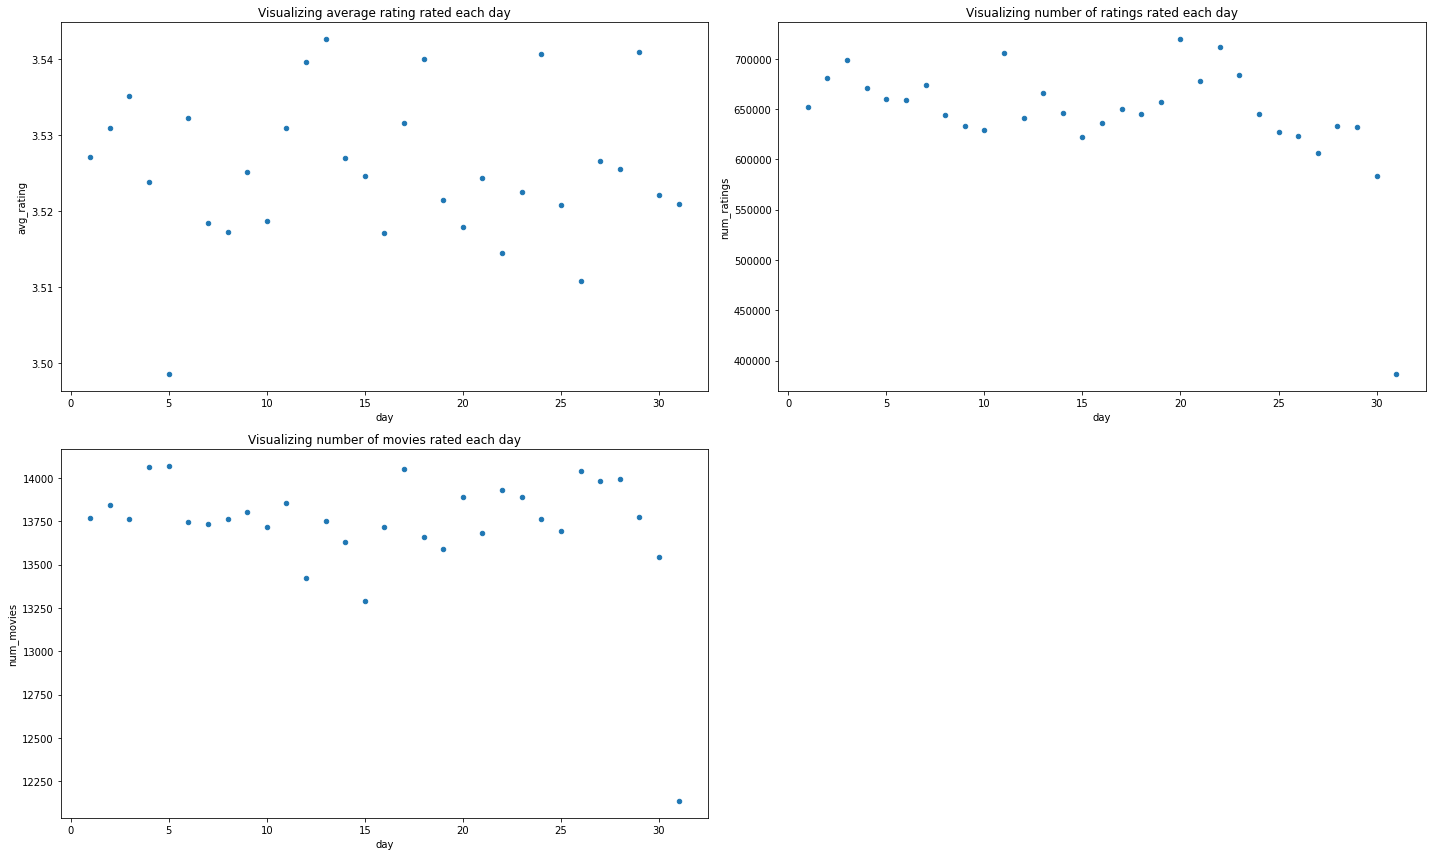

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

day_month_rating.plot.scatter("day", "avg_rating", ax=axes[0, 0])
axes[0, 0].set_title("Visualizing average rating rated each day")

day_month_rating.plot.scatter("day", "num_ratings", ax=axes[0, 1])
axes[0, 1].set_title("Visualizing number of ratings rated each day")

day_month_rating.plot.scatter("day", "num_movies", ax=axes[1, 0])
axes[1, 0].set_title("Visualizing number of movies rated each day")

fig.delaxes(axes[1, 1])
fig.tight_layout()

plt.show()


We find:

-   There is no clear pattern or relation between the `day of the month` with other features.


In [38]:
# Analyzing day of the week - Timestamp of rating
day_week_rating = (df
                   .withColumnRenamed("timestamp", "date")
                   .withColumn("day", F.dayofweek(F.col("date")))
                   .groupBy("day").agg(F.mean(F.col("rating")).alias("avg_rating"),
                                       F.countDistinct("movieId").alias(
                                           "num_movies"),
                                       F.countDistinct("movieId", "userId").alias("num_ratings"))
                   ).toPandas()


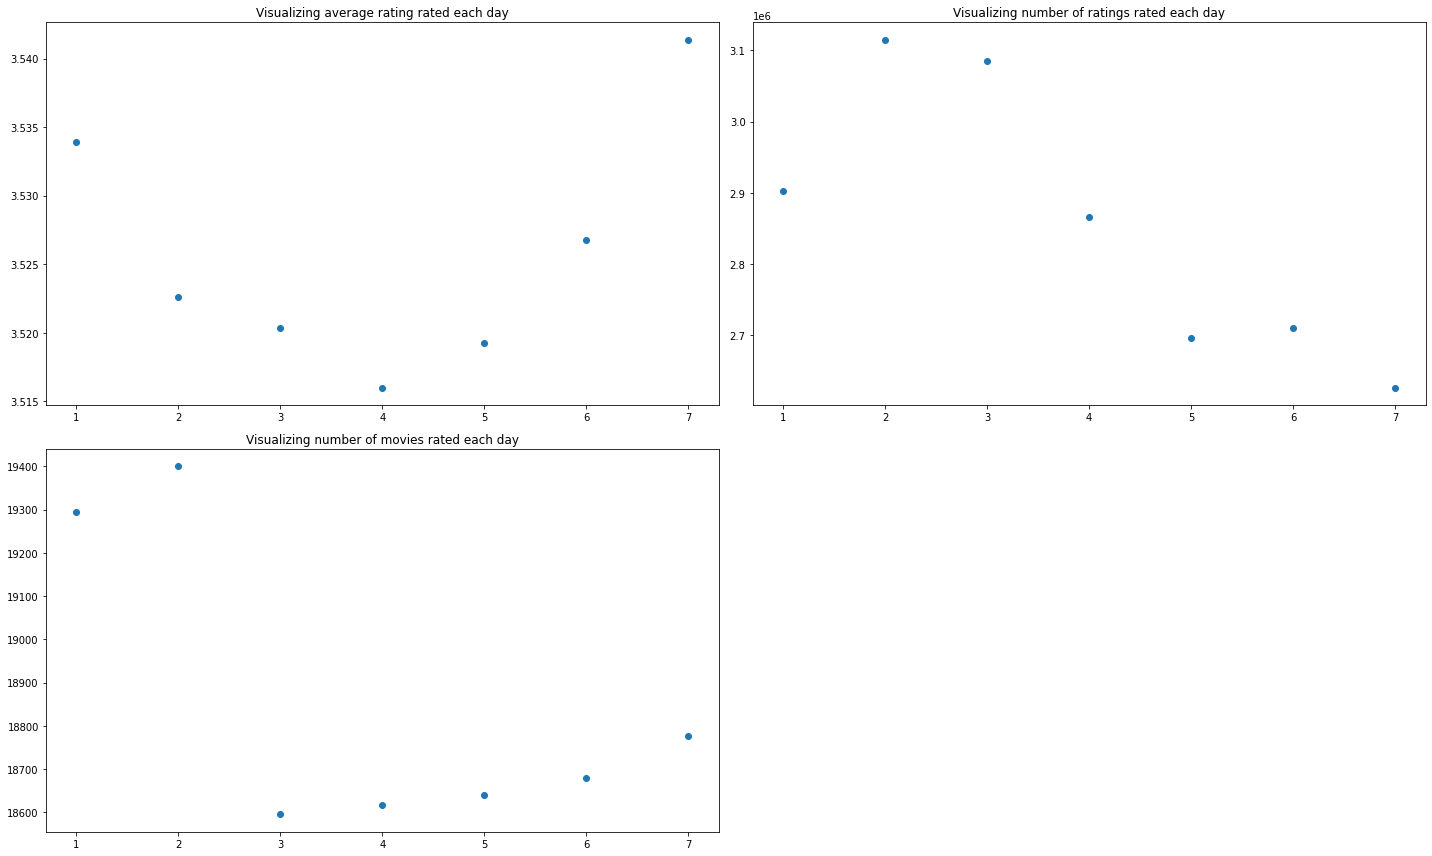

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

axes[0, 0].scatter(day_week_rating.day.astype(
    'int64'), day_week_rating.avg_rating)
axes[0, 0].set_title("Visualizing average rating rated each day")

axes[0, 1].scatter(day_week_rating.day.astype(
    'int64'), day_week_rating.num_ratings)
axes[0, 1].set_title("Visualizing number of ratings rated each day")

axes[1, 0].scatter(day_week_rating.day.astype(
    'int64'), day_week_rating.num_movies)
axes[1, 0].set_title("Visualizing number of movies rated each day")

fig.delaxes(axes[1, 1])
fig.tight_layout()

plt.show()


In [46]:
release_year_rating = (df
                       .select("title", "movieId", "userId", "rating")
                       .withColumn("releaseyear", F.substring('title', -5, 4))
                       .filter(F.col("releaseyear") > 1900)
                       .groupBy("releaseyear").agg(F.mean(F.col("rating")).alias("avg_rating"),
                                                   F.countDistinct("movieId").alias(
                                                       "num_movies"),
                                                   F.countDistinct("movieId", "userId").alias("num_ratings"))
                       ).toPandas()


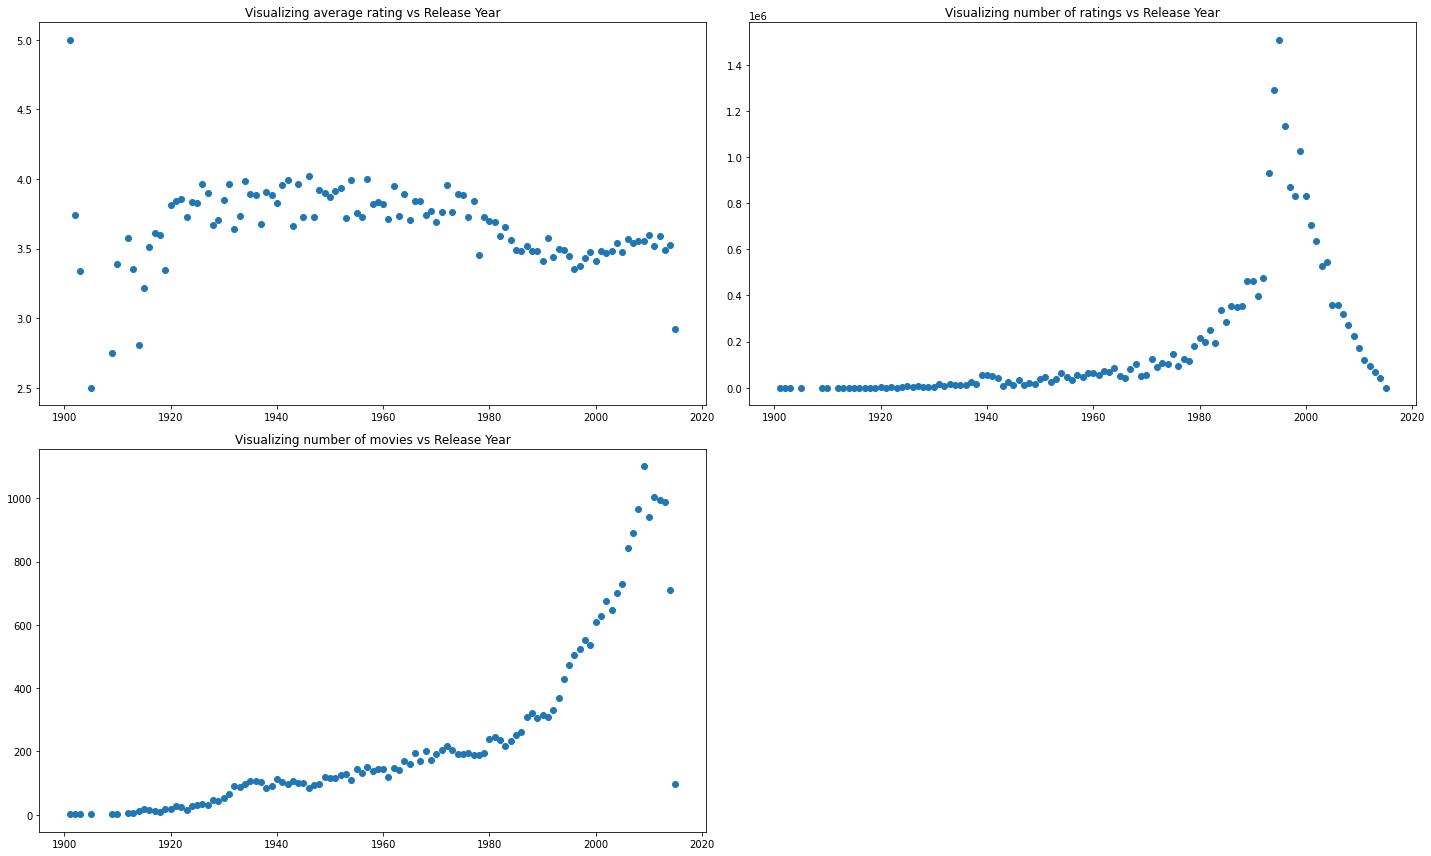

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

axes[0, 0].scatter(release_year_rating.releaseyear.astype(
    'int64'), release_year_rating.avg_rating)
axes[0, 0].set_title("Visualizing average rating vs Release Year")

axes[0, 1].scatter(release_year_rating.releaseyear.astype(
    'int64'), release_year_rating.num_ratings)
axes[0, 1].set_title("Visualizing number of ratings vs Release Year")

axes[1, 0].scatter(release_year_rating.releaseyear.astype(
    'int64'), release_year_rating.num_movies)
axes[1, 0].set_title("Visualizing number of movies vs Release Year")

fig.delaxes(axes[1, 1])
fig.tight_layout()

plt.show()


We find:

-   Number of movies have increased significantly over the years.
-   Number of rating has a weird uprise and drop.


## 4. Data Preparation


In [52]:
# Train Test split
(train, test) = df.select(
    ['userId', 'movieId', 'rating']).randomSplit([0.8, 0.2])


## 5. Model Building

Parameter Description:

-   `rank`: rank of the factorization
-   `maxIter`: max number of iterations (>= 0)
-   `regParam`: regularization parameter (>= 0)
-   `userCol`: column name for user ids. Ids must be within the integer value range
-   `itemCol`: column name for item ids. Ids must be within the integer value range
-   `ratingCol`: column name for ratings
-   `coldStartStrategy`: strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: 'nan', 'drop'


In [49]:
# Basic Model building
als = ALS(rank=10, maxIter=4, regParam=0.1, userCol='userId',
          itemCol='movieId', ratingCol='rating', coldStartStrategy="drop")

# Define evaluator as RMSE
evaluator = RegressionEvaluator(
    metricName="rmse", labelCol="rating", predictionCol="prediction")


In [53]:
% % time
# Fit the model
model = als.fit(train)


CPU times: user 168 ms, sys: 40.7 ms, total: 209 ms
Wall time: 3min 24s


In [54]:
# Evaluate the model
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)

print('The RMSE for our model is: {}'.format(rmse))


The RMSE for our model is: 0.8176288680275328


### 5.1. Improving the model

One way to improve the model is to tune the hyperparameter of the model. `CrossValidator` is familiar with sklearn's `cross_val_score` and `ParamGridBuilder` is a builder for a param grid used in grid search-based model selection.

The cross validation consumes enormouse amout of time and hence, below you can find the skeleton code to perform hyper parameter tuning.


In [56]:
# Define the model parameter grid
param_grid = ParamGridBuilder()\
    .addGrid(als.rank, [12, 13, 14])\
    .addGrid(als.maxIter, [18, 19, 20])\
    .addGrid(als.regParam, [0.05, 0.5, 0.1])\
    .build()

# Initialize the cross validator
crossVal = CrossValidator(
    estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10)

# Fit the model and perform cross validation
cvModel = crossVal.fit(train)

# Evaluate the model
cvPredictions = cvModel.transform(test)
cvRmse = evaluator.evaluate(cvPredictions)

print('The RMSE for our model is: {}'.format(cvRmse))


## 6. Recommend Movies

To recommend movies for a specific user, below is a function that applies the trained model, ALSModel, on the list of movies that the user hasn't yet rated


In [58]:
def recommendMovies(model, user, nRecommendation):
    # Create a Spark DataFrame with the specified user and all the movies listed in the ratings DataFrame
    dataSet = ratings.select('movieId').distinct(
    ).withColumn('userId', F.lit(user))

    # Create a Spark DataFrame with the movies that have already been rated by this user
    moviesAlreadyRated = ratings.filter(
        ratings.userId == user).select('movieId', 'userId')

    # Apply the recommender system to the data set without the already rated movies to predict ratings
    predictions = model.transform(dataSet.subtract(moviesAlreadyRated)).dropna().orderBy(
        'prediction', ascending=False).limit(nRecommendation).select('movieId', 'prediction')

    # Join with the movies DataFrame to get the movies titles and genres
    recommendations = predictions.join(movies, predictions.movieId == movies.movieId).select(
        predictions.movieId, movies.title, movies.genres, predictions.prediction)

    return recommendations


Now run this function to recommend 10 movies for different users:


In [59]:
print('Recommendations for user 153:')
recommendMovies(model, 153, 10).toPandas()


Recommendations for user 153:


,movieId,title,genres,prediction
0,81117,"Moth, The (Cma) (1980)",Drama,6.064673
1,82328,One Fine Spring Day (Bomnaleun ganda) (2001),Drama,5.925478
2,109887,"Great Passage, The (Fune wo amu) (2013)",Drama,5.818318
3,116183,It's Love I'm After (1937),Comedy,5.911806
4,117907,My Brother Tom (2001),Drama,6.311569
5,120134,Doggiewoggiez! Poochiewoochiez! (2012),Comedy,6.050812
6,120821,The War at Home (1979),Documentary|War,6.015426
7,121029,No Distance Left to Run (2010),Documentary,6.553770
8,129536,Code Name Coq Rouge (1989),(no genres listed),6.092913
9,130347,Bill Hicks: Sane Man (1989),Comedy,5.887615


In [60]:
print('Recommendations for user 250:')
recommendMovies(model, 250, 10).toPandas()


Recommendations for user 250:


,movieId,title,genres,prediction
0,26793,Tito and Me (Tito i ja) (1992),Comedy,4.924314
1,103593,Taming the Fire (Ukroshcheniye ognya) (1972),Documentary|Drama|Sci-Fi,4.850996
2,104317,Flight of the Conchords: A Texan Odyssey (2006),Comedy,4.919813
3,107434,Diplomatic Immunity (2009– ),Comedy,4.923127
4,110669,"Honest Liar, An (2014)",Comedy|Documentary,4.900411
5,118338,Hard to Be a God (2013),Sci-Fi,4.911441
6,120134,Doggiewoggiez! Poochiewoochiez! (2012),Comedy,5.056443
7,121029,No Distance Left to Run (2010),Documentary,5.534087
8,128091,Craig Ferguson: A Wee Bit o' Revolution (2009),Comedy,5.608799
9,130347,Bill Hicks: Sane Man (1989),Comedy,5.114568


## Thank you

Share if you liked it, comment if you loved it. Hope to see you guys in the next one. Peace!


## Resources

1. [ML Tuning: Model Selection and Hyperparameter Tuning Using PySpark](https://spark.apache.org/docs/latest/ml-tuning.html)
2. [ALS](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html)
3. [PySpark Documentation](https://spark.apache.org/docs/latest/api/python/getting_started/index.html)


## Data Citation

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872
